In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv


In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score


In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv")
test_df  = pd.read_csv("/kaggle/input/playground-series-s5e12/test.csv")
sample_sub = pd.read_csv("/kaggle/input/playground-series-s5e12/sample_submission.csv")
print(train_df.head())
TARGET = "diagnosed_diabetes"


   id  age  alcohol_consumption_per_week  physical_activity_minutes_per_week  \
0   0   31                             1                                  45   
1   1   50                             2                                  73   
2   2   32                             3                                 158   
3   3   54                             3                                  77   
4   4   54                             1                                  55   

   diet_score  sleep_hours_per_day  screen_time_hours_per_day   bmi  \
0         7.7                  6.8                        6.1  33.4   
1         5.7                  6.5                        5.8  23.8   
2         8.5                  7.4                        9.1  24.1   
3         4.6                  7.0                        9.2  26.6   
4         5.7                  6.2                        5.1  28.8   

   waist_to_hip_ratio  systolic_bp  ...  gender  ethnicity  education_level  \
0            

In [4]:
# Split features & target
X = train_df.drop(columns=[TARGET, "id"])
y = train_df[TARGET]
X_test = test_df.drop(columns=["id"])

# Auto-detect categorical columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# One-hot encode
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Align train & test
X, X_test = X.align(X_test, join="left", axis=1, fill_value=0)


In [5]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [6]:
model = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)


In [7]:
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric=["auc", "binary_logloss"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=200)
    ]
)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 349046, number of negative: 210954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.715531	training's binary_logloss: 0.62336	valid_1's auc: 0.712842	valid_1's binary_logloss: 0.62555
[400]	training's auc: 0.723373	training's binary_logloss: 0.612423	valid_1's auc: 0.719332	vali

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.01, n_estimators=2000, n_jobs=-1, num_leaves=64,
               objective='binary', random_state=42, subsample=0.8)

In [8]:
val_preds = model.predict_proba(X_val)[:, 1]

print("Validation AUC:", roc_auc_score(y_val, val_preds))
print("Validation Accuracy:", accuracy_score(y_val, (val_preds > 0.5).astype(int)))


Validation AUC: 0.7258885813330728
Validation Accuracy: 0.6550785714285714


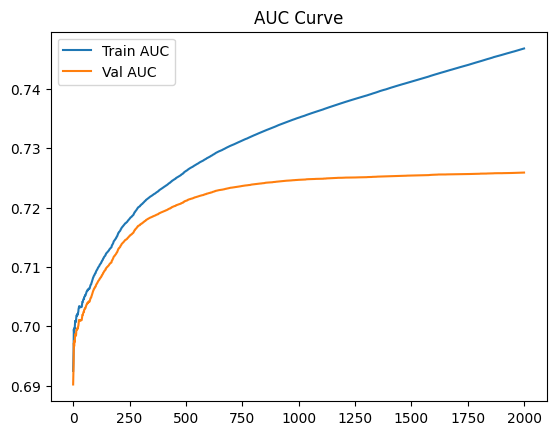

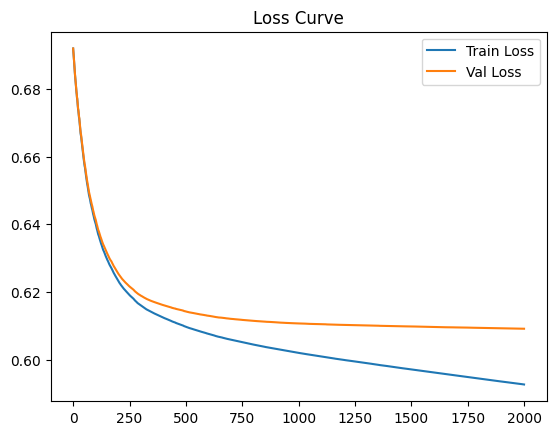

In [9]:
evals = model.evals_result_

# AUC
plt.figure()
plt.plot(evals['training']['auc'], label='Train AUC')
plt.plot(evals['valid_1']['auc'], label='Val AUC')
plt.legend()
plt.title("AUC Curve")
plt.show()

# Log Loss
plt.figure()
plt.plot(evals['training']['binary_logloss'], label='Train Loss')
plt.plot(evals['valid_1']['binary_logloss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


In [10]:
test_preds = model.predict_proba(X_test)[:, 1]
sample_sub[TARGET] = test_preds
sample_sub.to_csv("submission.csv", index=False)
